# <b>Generative Adversial Networks (GANs) for image generation</b>

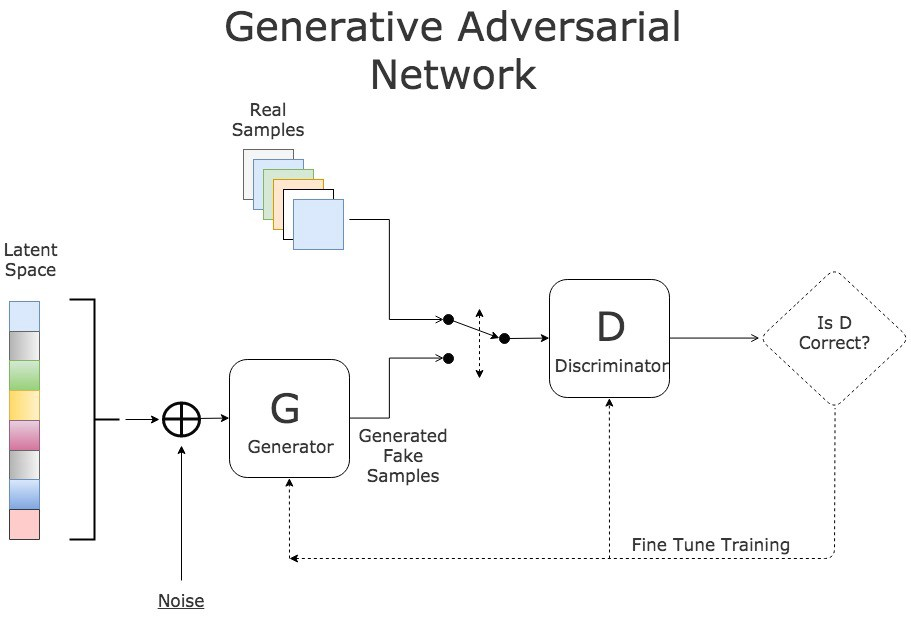
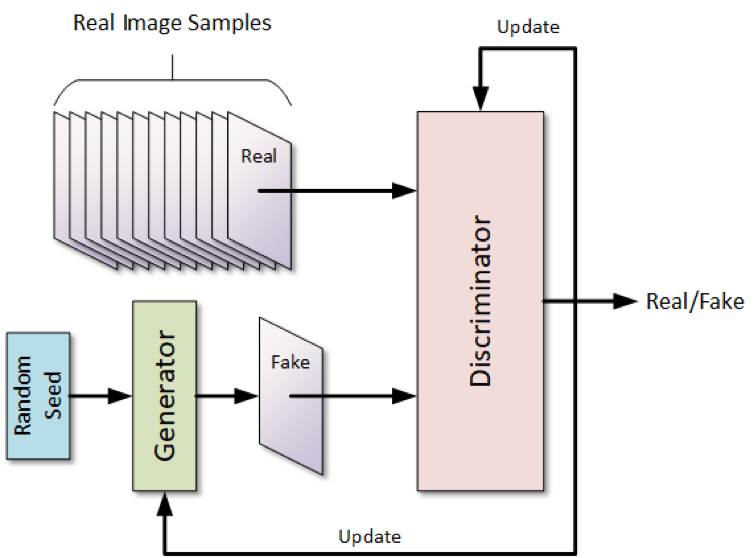
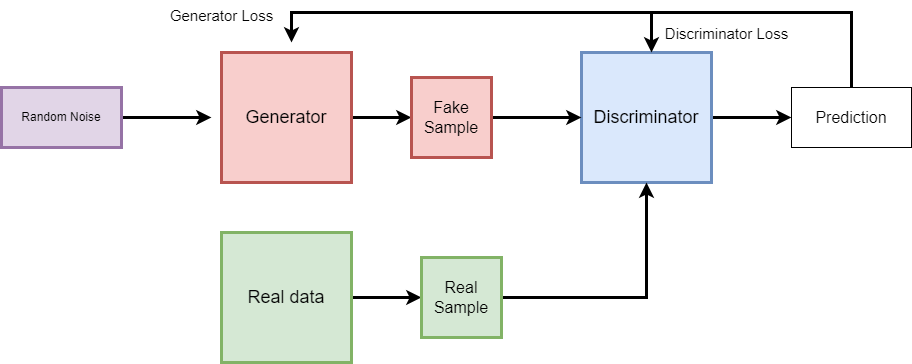

In [111]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [112]:
np.random.seed(42)

(X_train, y_train), (X_test, y_test ) = tf.keras.datasets.mnist.load_data()

X_train = X_train.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))

print(f"X_train min: {X_train.min()}")
print(f"X_train max: {X_train.max()}")
print(f"X_train: {X_train.shape}")

X_train min: 0
X_train max: 255
X_train: (60000, 28, 28, 1)


In [113]:
class Generator:
    def __init__(self, latent_dimension) -> None:
        self.latent_dimension = latent_dimension
        
        # Define the model architecture
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(7 * 7 * 128, activation='relu', input_dim=self.latent_dimension),
            tf.keras.layers.Reshape((7, 7, 128)),  # Reshape into a 7x7x128 tensor
            
            # Upsampling to 14x14x128
            tf.keras.layers.UpSampling2D(),
            tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(momentum=0.8),
            
            # Upsampling to 28x28x128
            tf.keras.layers.UpSampling2D(),
            tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(momentum=0.8),
            
            # Output layer to get the final 28x28x1 image
            tf.keras.layers.Conv2D(1, 3, padding='same', activation='tanh')
        ])
        
        # Noise input (latent vector z) and label input
        z = tf.keras.layers.Input(shape=(self.latent_dimension,))
        label = tf.keras.layers.Input(shape=(1,), dtype='uint8')
        
        # Embedding the label into the latent space and flattening it
        label_embedded = tf.keras.layers.Embedding(input_dim=10, output_dim=self.latent_dimension)(label)
        label_embedded = tf.keras.layers.Flatten()(label_embedded)
        
        # Combine the noise and label embedding (element-wise multiplication)
        combined = tf.keras.layers.multiply([z, label_embedded])
        
        # Generate the image
        img = model(combined)
        
        # Create the model
        self.generator_model = tf.keras.models.Model([z, label], img)

    def summary(self):
        """Print the summary of the generator model."""
        self.generator_model.summary()

# Instantiate the generator
generator = Generator(latent_dimension=100)

# Print the summary of the model
generator.summary()

Model: "functional_268"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_445     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_117       │ (None, 1, 100)    │      1,000 │ input_layer_445[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_444     │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_123         │ (None, 100)       │          0 │ embedding_117[0]… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_55         │ (None, 100)       │          0 │ input_layer_444[… │
│ (Multiply)          │                   │            │ flatten_123[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_123      │ (None, 28, 28, 1) │    856,193 │ multiply_55[0][0] │
│ (Sequential)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 857,193 (3.27 MB)

 Trainable params: 856,809 (3.27 MB)

 Non-trainable params: 384 (1.50 KB)

In [114]:
class Discriminator:
    def __init__(self) -> None:
        model = tf.keras.Sequential([
            # Convolutional layers for feature extraction
            tf.keras.layers.Conv2D(32, (3, 3), strides=2, padding="same", input_shape=(28, 28, 2)),  # Input shape updated
            tf.keras.layers.LeakyReLU(0.2),
            tf.keras.layers.Dropout(0.25),
            
            tf.keras.layers.Conv2D(64, (3, 3), strides=2, padding="same"),
            tf.keras.layers.LeakyReLU(0.2),
            tf.keras.layers.Dropout(0.25),
            
            # Flatten layer to connect the conv layers to the fully connected layer
            tf.keras.layers.Flatten(),
            
            # Fully connected layers
            tf.keras.layers.Dense(512, activation="relu"),
            tf.keras.layers.Dropout(0.25),
            
            # Output layer (single neuron with sigmoid activation for binary classification)
            tf.keras.layers.Dense(1, activation="sigmoid")
        ])
        
        # Input layers for the image and label
        img = tf.keras.layers.Input(shape=(28, 28, 1))  # MNIST images have shape (28, 28, 1)
        label = tf.keras.layers.Input(shape=(1,))  # Label is a scalar integer (0-9)
        
        # Embed the label into a higher-dimensional space and reshape it into (28, 28, 1)
        label_embedded = tf.keras.layers.Embedding(input_dim=10, output_dim=np.prod((28, 28)))(label)
        label_embedded = tf.keras.layers.Reshape((28, 28, 1))(label_embedded)
        
        # Concatenate the label embedding with the image (cGAN)
        concatenated = tf.keras.layers.Concatenate(axis=-1)([label_embedded, img])
        
        # Pass the concatenated tensor through the model to get the prediction
        prediction = model(concatenated)
        
        # Create the discriminator model
        self.discriminator_model = tf.keras.models.Model([img, label], prediction)

    def summary(self):
        """Print the summary of the discriminator model."""
        self.discriminator_model.summary()

# Instantiate and summarize the Discriminator model
discriminator = Discriminator()
discriminator.summary()

Model: "functional_270"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_448     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_118       │ (None, 1, 784)    │      7,840 │ input_layer_448[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_123         │ (None, 28, 28, 1) │          0 │ embedding_118[0]… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_447     │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_61      │ (None, 28, 28, 2) │          0 │ reshape_123[0][0… │
│ (Concatenate)       │                   │            │ input_layer_447[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_124      │ (None, 1)         │  1,625,761 │ concatenate_61[0… │
│ (Sequential)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,633,601 (6.23 MB)

 Trainable params: 1,633,601 (6.23 MB)

 Non-trainable params: 0 (0.00 B)

In [115]:
class CGAN:
    def __init__(self, latent_dimension) -> None:
        self.latent_dimension = latent_dimension
        self.discriminator = Discriminator()  
        self.generator = Generator(latent_dimension=self.latent_dimension)
        
        # Compile the discriminator
        self.discriminator.discriminator_model.compile(
            loss="binary_crossentropy",
            optimizer="adam",
            metrics=['accuracy']
        )
        
        # Inputs for the generator and discriminator
        z = tf.keras.layers.Input(shape=(self.latent_dimension,))  # Latent vector input
        label = tf.keras.layers.Input(shape=(1,))  # Label input
        img = self.generator.generator_model([z, label])  # Generate an image using the generator
        
        # Freeze the discriminator during the training of the CGAN model (generator training)
        self.discriminator.discriminator_model.trainable = False
        prediction = self.discriminator.discriminator_model([img, label])  # Get discriminator prediction
        
        # Define the CGAN model
        self.cgan_model = tf.keras.models.Model([z, label], prediction)
        
        # Compile the CGAN model
        self.cgan_model.compile(
            loss="binary_crossentropy",
            optimizer="adam",
            metrics=["accuracy"]
        )
    
    def plot_image(self, images, labels, rows, cols):
        fig = plt.figure(figsize=(8, 8))
        for i in range(1, cols*rows + 1):
            img = images[i-1]
            ax = fig.add_subplot(rows, cols, i)
            ax.title.set_text(labels[i-1])
            plt.imshow(img.reshape((28, 28)))
        fig.tight_layout()
        plt.show()
        
    def train(self, X_train, y_train, batch_size, save_interval, epochs):
        valid = np.ones((batch_size, 1))  # Real images are labeled 1
        fake = np.zeros((batch_size, 1))  # Fake images are labeled 0
        
        losses = {"G": [], "D": []}
        
        samples_test = np.random.normal(0, 1, (16, 100))  # Random noise for testing
        labels_test = np.random.randint(0, 10, 16).reshape((-1, 1))  # Random labels for testing
        
        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            real_images, labels = X_train[idx], y_train[idx]
            noise = np.random.normal(0, 1, (batch_size, 100))  # Latent noise vector
            fake_images = self.generator.generator_model.predict([noise, labels])
            
            # Train discriminator
            self.discriminator.discriminator_model.trainable = True
            discriminator_loss_real = self.discriminator.discriminator_model.train_on_batch([real_images, labels], valid)
            discriminator_loss_fake = self.discriminator.discriminator_model.train_on_batch([fake_images, labels], fake)
            discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)
            self.discriminator.discriminator_model.trainable = False
            
            # Train generator
            generator_loss = self.cgan_model.train_on_batch([noise, labels], valid)
            losses["G"].append(generator_loss)
            losses["D"].append(discriminator_loss)
            
            # Save generated images at intervals
            if epoch % save_interval == 0:
                print(f"Epoch {epoch} - D Loss: {discriminator_loss[0]}, G Loss: {generator_loss}")
                results = self.generator.generator_model.predict([samples_test, labels_test])
                self.plot_image(results, labels_test, 4, 4)
    
    def summary(self):
        """Print the summary of the CGAN model."""
        self.cgan_model.summary()

# Example usage:
latent_dimension = 100
batch_size = 128
epochs = 15000  # Make sure the number of epochs is defined
save_interval = 100
cgan = CGAN(latent_dimension=latent_dimension)
cgan.summary()
cgan.train(X_train=X_train, y_train=y_train, batch_size=batch_size, save_interval=save_interval, epochs=epochs)

Model: "functional_275"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_455     │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_456     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_274      │ (None, 28, 28, 1) │    857,193 │ input_layer_455[… │
│ (Functional)        │                   │            │ input_layer_456[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_272      │ (None, 1)         │  1,633,601 │ functional_274[0… │
│ (Functional)        │                   │            │ input_layer_456[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,490,794 (9.50 MB)

 Trainable params: 856,809 (3.27 MB)

 Non-trainable params: 1,633,985 (6.23 MB)

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step

c:\Users\PanCh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_2238', 'keras_tensor_2239']. Received: the structure of inputs=('*', '*')
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


AttributeError: 'NoneType' object has no attribute 'update_state'